<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Chat_with_code_repositories_using_codellama_using_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Required Packages

In [ ]:
!pip install -qU langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install -q ctransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.1 MB/s eta 0:00:00


In [ ]:
!pip install -q faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.1 MB/s eta 0:00:00


In [21]:
!pip install -qU sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.3 MB/s eta 0:00:00


## Clone a repository from github

In [13]:
!git clone https://github.com/plaban1981/st_question_answer_app

Cloning into 'st_question_answer_app'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 49 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (49/49), 61.24 KiB | 5.57 MiB/s, done.
Resolving deltas: 100% (18/18), done.


## Import reuired libraries

In [27]:
from langchain.llms import CTransformers
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import Language
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import LanguageParser
from langchain.chains.question_answering import load_qa_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate

## Set repo path

In [14]:
repo_path = "/content/st_question_answer_app"

## Load the data using data loaders

In [15]:
loader = GenericLoader.from_filesystem(
    repo_path,
    glob="**/*",
    suffixes=[".py"],
    parser=LanguageParser(language=Language.PYTHON, parser_threshold=10)
)
documents = loader.load()
len(documents)

4

## Print the documents loaded

In [16]:
for i in documents:
  print(i,"\n------------------------------------------------------\n")


page_content='def preprocess_function(text_path,content_type = None ):\n    prompt=f"Generate  Multiple Questions and Answers from the context provided.\\n\\nContext :{text_path}\\n\\n"\n    return prompt' metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'functions_classes', 'language': <Language.PYTHON: 'python'>} 
------------------------------------------------------

page_content='def predict_function(prompt): \n    print(prompt)\n    response = openai.Completion.create(\n                model="text-davinci-003",\n                prompt=prompt,\n                temperature=0.7,\n                max_tokens=300,\n                top_p=1,\n                frequency_penalty=0,\n                presence_penalty=0\n                )\n    answer = response.choices[0].text\n    print(answer)\n    return answer' metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'functions_classes', 'language': <Language.PYTHON: 'python'>} 
-

## Generate required text chunks

In [18]:
python_splitter = RecursiveCharacterTextSplitter.from_language(language=Language.PYTHON,
                                                               chunk_size=500,
                                                               chunk_overlap=100)
texts = python_splitter.split_documents(documents)
len(texts)

13

In [19]:
texts[0]

Document(page_content='def preprocess_function(text_path,content_type = None ):\n    prompt=f"Generate  Multiple Questions and Answers from the context provided.\\n\\nContext :{text_path}\\n\\n"\n    return prompt', metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'functions_classes', 'language': <Language.PYTHON: 'python'>})

## Initialize Embeddings

In [23]:
embeddings  = HuggingFaceEmbeddings(model_name="thenlper/gte-large",
                                    model_kwargs={"device":"cpu"})

## Create a vectorstore

In [24]:
db = FAISS.from_documents(texts, embeddings)


## Instantiate Retriever

In [25]:
retriever = db.as_retriever(search_kwargs={"k":2})

## Instantiate LLM

In [26]:
llm = CTransformers(model="TheBloke/CodeLlama-7B-Instruct-GGUF",
                    model_file="codellama-7b-instruct.Q4_K_M.gguf",
                    temperature=0.7,
                    max_new_tokens=1000,
                    do_sample=True)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

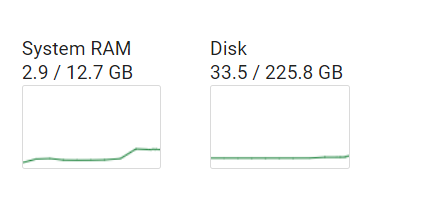

## Instantiate Question Answering chain

In [29]:
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(
    input_variables=["context", "question"],
    template=template
)
#
chain = load_qa_chain(llm, chain_type="stuff", prompt=QA_CHAIN_PROMPT)

## Ask Questions

In [30]:
question = "Can I use streamlit to create an application interface for question answer app. If yes what is the code for that?"
docs = retriever.get_relevant_documents(question)
chain({"input_documents": docs, "question": question})

{'input_documents': [Document(page_content='import streamlit as st\nfrom PIL import Image\nimport requests\nimport pandas as pd\nimport os\nimport json\n#\nimage_path = "image.jpg"\nimage = Image.open(image_path)', metadata={'source': '/content/st_question_answer_app/app.py', 'content_type': 'simplified_code', 'language': <Language.PYTHON: 'python'>}),
  Document(page_content='import streamlit as st\nfrom streamlit import secrets\nimport openai\nimport os\nimport json\nfrom PIL import Image\nimport pandas as pd\n\n#\nimage_path = "image.jpg"\nimage = Image.open(image_path)\n#\napi_key = secrets["API_KEY"]\nopenai.api_key = api_key\nprint(api_key)\n#\n\n# Code for: def preprocess_function(text_path,content_type = None ):', metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'simplified_code', 'language': <Language.PYTHON: 'python'>})],
 'question': 'Can I use streamlit to create an application interface for question answer app. If yes what is the code for 

In [31]:
%%time
question = "Please share the lidt of python packages used in the code."
docs = retriever.get_relevant_documents(question)
chain({"input_documents": docs, "question": question})

CPU times: user 5min, sys: 586 ms, total: 5min
Wall time: 3min 9s


{'input_documents': [Document(page_content='import streamlit as st\nfrom streamlit import secrets\nimport openai\nimport os\nimport json\nfrom PIL import Image\nimport pandas as pd\n\n#\nimage_path = "image.jpg"\nimage = Image.open(image_path)\n#\napi_key = secrets["API_KEY"]\nopenai.api_key = api_key\nprint(api_key)\n#\n\n# Code for: def preprocess_function(text_path,content_type = None ):', metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'simplified_code', 'language': <Language.PYTHON: 'python'>}),
  Document(page_content='# Code for: def preprocess_function(text_path,content_type = None ):\n\n# \n@st.cache\n# Code for: def predict_function(prompt): \n   \n#\nst.image(image, caption=\'Question & Answer Generator\')\nst.write("""## ⚡️ Question & Answer Generator App ⚡️""")\n\nquery = st.text_input("Enter the Context here.", "")', metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'simplified_code', 'language': <Languag

In [33]:
%%time
question = "Please share the streamlit code to write text information used in the python files."
docs = retriever.get_relevant_documents(question)
chain({"input_documents": docs, "question": question})

CPU times: user 1min 43s, sys: 743 ms, total: 1min 44s
Wall time: 1min 13s


{'input_documents': [Document(page_content='import streamlit as st\nfrom streamlit import secrets\nimport openai\nimport os\nimport json\nfrom PIL import Image\nimport pandas as pd\n\n#\nimage_path = "image.jpg"\nimage = Image.open(image_path)\n#\napi_key = secrets["API_KEY"]\nopenai.api_key = api_key\nprint(api_key)\n#\n\n# Code for: def preprocess_function(text_path,content_type = None ):', metadata={'source': '/content/st_question_answer_app/app_gpt3.py', 'content_type': 'simplified_code', 'language': <Language.PYTHON: 'python'>}),
  Document(page_content='import streamlit as st\nfrom PIL import Image\nimport requests\nimport pandas as pd\nimport os\nimport json\n#\nimage_path = "image.jpg"\nimage = Image.open(image_path)', metadata={'source': '/content/st_question_answer_app/app.py', 'content_type': 'simplified_code', 'language': <Language.PYTHON: 'python'>})],
 'question': 'Please share the streamlit code to write text information used in the python files.',
 'output_text': ' stre